# BlackLiveMatter Hashtag Analysis in Indonesia

In [2]:
import pickle
import pandas as pd, numpy as np

from elang.plot.utils import plot2d, plotNeighbours
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from scipy import spatial

from tqdm import tqdm
import helper

In [3]:
import importlib
importlib.reload(helper)

<module 'helper' from '/Users/iqbalbasyar/Documents/onego/Twitter Analysis/blacklivesmatter/helper.py'>

# 1. Preparations

## Gather Tweet Data
This data contains ~20k tweets as the reuslt of search query api "#blacklivesmatters OR #blacklivesmatter" on May 30th, 2020 in Indonesia. The original data was saved as `tweepy.models.Status`. But we will take several information and transform it into DataFrame. 

We choose the data in order to analyze current (today is May 30) hot topics about george floyd in Indonesia. The main motivation is about human rights.

The data was collected using twitter api in `get_tweet.ipynb`
```

In [3]:
with open('data/tweet_blm', 'rb') as file:
    tweet_blm = pickle.load(file)
    
tweets = helper.tweetlist2df(tweet_blm)
tweets.head()

100%|██████████| 19093/19093 [00:00<00:00, 88891.53it/s]


text                   id  \
0  RT @OpRahim: Aku perhati je orang2 yg aku kena...  1266645938933600256   
1  RT @seoqjinx: Dari pada nyebar hati ungu. Mend...  1266645921527238656   
2  RT @joonsharmony: halo semuanya. disini aku co...  1266645915521085441   
3  RT @notfatra: Buat yang belum tau baca ini nih...  1266645913960771584   
4  RT @seoqjinx: Dari pada nyebar hati ungu. Mend...  1266645898978721793   

                userid       username          created_at  likes  retweets  \
0            528681194        OpRahim 2020-05-30 08:21:39      0         2   
1           4911688255  LittleBambiJK 2020-05-30 08:21:35      0       444   
2   942796746593148928      r_beomjin 2020-05-30 08:21:34      0       207   
3  1011243693141946372  staerryskies_ 2020-05-30 08:21:33      0       172   
4  1194409236576366592  AsriFadillah8 2020-05-30 08:21:30      0       444   

   isquote  is_retweet        mentions  \
0    False        True       [OpRahim]   
1    False        True      [seoqjinx]   
2    False        True  [joonsharmony]   
3    False        True      [notfatra]   
4    False        True      [seoqjinx]   

                                            hashtags  reply_to   geo place  
0                                 [BlacklivesMaters]       NaN  None  None  
1  [BlacklivesMaters, RAISETHEDEGREE, BlacklivesM...       NaN  None  None  
2                                                 []       NaN  None  None  
3                                [BlackLivesMatters]       NaN  None  None  
4  [BlacklivesMaters, RAISETHEDEGREE, BlacklivesM...       NaN  None  None

## Preprocessing 
Since we are going to build an activity network, we will normalize interactions (mentions) between user. Every user that mentions more than one username will be splitted into lines. 

We will also clean the text so that we can build better word2vec model later.

In [4]:
# Normalize each row for user who mentions more than 2 username, and save it as csv
# tweeet = separate_rows(tweeet, 'mentions')
# tweeet.to_csv('tweet_black_lives_matter.csv', index=False)

In [5]:
# Text Cleansing : 
# Remove urls, indonesian stopwords, laugh, emoticons, and punctuations using 

# clean_text = []
# for text in tqdm(tweets['text']):
#     clean_text.append(helper.clean_teks(text))
# tweets['text_clean'] = clean_text
# tweets.to_csv('tweet_black_lives_matter_clean.csv', index=False)

In [6]:
# Read pre-processed text
tweets = pd.read_csv('data/tweet_black_lives_matter_clean.csv')

In [7]:
# get all hashtags
hashtags = []
for tweet in tweet_blm:
    if (hashtag:=tweet.entities['hashtags']) != []:
        hashtags.extend([tag['text'] for tag in hashtag])

In [8]:
# get all mentions
mentions = []
for tweet in tweet_blm:
    if (users:=tweet.entities['user_mentions']) != []:
        mentions.extend([user['screen_name'] for user in users])

# 2. Activity Network

in credits to complete @joe's task

## Create Network From DataFrame
Since the process may take a while, we will read the edges and nodes from preprocessed tweet. We build directed graph because the activity (retweet and reply) is one-way connection in graph. 

In [9]:
# load pre-processed csv and make edges dataframe to visualize the networks
# df= pd.read_csv('data/tweet_black_lives_matter.csv', usecols=['username', 'mentions', 'is_retweet'])
# df['type'] = df['is_retweet'].apply(lambda x: 'retweet' if x == True else 'reply')
# edges = df[['mentions', 'username', 'type']]
# edges.columns = ['from', 'to','type']
# edges['count'] = 1
# edges = edges.groupby(['from', 'to', 'type']).sum().reset_index()
# nodes = pd.DataFrame(set(edges[['from', 'to']].values.flatten()), columns=['username'])

# nodes.to_csv('data/nodes.csv', index=False)
# edges.to_csv('data/edges.csv', index=False)

In [10]:
# load pre-processed nodes and edges
nodes = pd.read_csv('data/nodes.csv')
edges = pd.read_csv('data/edges.csv')

In [11]:
nodes.head(3)

username
0     bigelsluvtae
1  Rebahan_IsLyfeu
2       Ash_____XO

In [12]:
edges.head(3)

from           to     type  count
0  1994KIMNJ  crownforkth    reply      1
1  1994KIMNJ     hlgiyana  retweet      2
2  1994KIMNJ     may_Njel  retweet      2

Then using R, we create the graph with `group_walktrap()` algorithm on making the community. 
We also measure degree, betweenes,closeness, and eigen centrality method to determine the key player. 

```r
network_nn <- graph_from_data_frame(d = edges, vertices = nodes, directed = T) %>%
  as_tbl_graph()

# create community, calculate centrality and remove loop edge
set.seed(123)
network_nn <- network_nn %>% 
  activate(nodes) %>%
  mutate(community = group_walktrap(),
         degree = centrality_degree(),
         between = centrality_betweenness(),
         closeness = centrality_closeness(),
         eigen = centrality_eigen()) %>%
  activate(edges) %>%
  filter(!edge_is_loop())

user_activity <- as.data.frame(network_nn %>% activate(nodes))
write.csv(user_activity, 'data/user_activity.csv')
```

## Finding Key Player


In order to see how this tweet spread in Indonesia, we took some user as a key player. From total activities (likes and retweets), here are several names that contributes the most.

In [13]:
topuser = tweets.copy()
topuser['total'] = topuser['likes'] + topuser['retweets']
topuser = topuser.groupby('username').sum().sort_values(by='total', ascending=False)[['likes', 'retweets']]
topuser.head(10)

likes  retweets
username                     
anpamanz      369.0    1013.0
txtdrindomy   586.0     516.0
notfatra      650.0     181.0
euphojiia19    89.0     615.0
maritzaurel_  502.0     189.0
kimthxv_      103.0     542.0
uyonisti96    386.0     183.0
seoqjinx       79.0     477.0
prknyaaa      282.0     209.0
strwbrryera   310.0     169.0

But we also have the measure of degree, betweenness, closeness, and eigen below. Since the virality of tweet depends on how much and how fast the tweet is posted in specific timeline, we should focus on betweenness and closeness. We use betweenness to see user who gives the most potential reach, and closeness to see user who can spread the tweet quickly. 

In [14]:
user_activity = pd.read_csv('data/kp_activity.csv')
user_activity

degree      betweenness      closeness            eigen
0         anpamanz           ZhyLu_       anpamanz         anpamanz
1      euphojiia19      euphojiia19    txtdrindomy         kimthxv_
2         kimthxv_         kimthxv_   joonsharmony      euphojiia19
3         seoqjinx        daeguttae       prknyaaa         seoqjinx
4      txtdrindomy         seoqjinx    jggukminsea  ItikNoodleSoup_
5  ItikNoodleSoup_          jungsmy  sprinkletaegi           ZhyLu_
6       plantaekoo  chimins_lcvebot     blackswagn   jamaisvuphoria
7   jamaisvuphoria        hobie1301        oohawii        daeguttae
8       childxhnyh          klgrxra     plantaekoo       plantaekoo
9         prknyaaa        onfilterz    beingclingy       childxhnyh

Based on two table above, we see that **"anpamanz" and "euphojiia19" is the most contributing key player**. Let's see the tweet example and network visualization below. 

In [15]:
for i, row in  tweets[tweets['username'].isin(['anpamanz', 'euphojiia19'])].iterrows():
    print(f"Tweet from : {row['username']}")
    print(row['text'])
    print('____')

Tweet from : anpamanz
guys, bantu tenggelemin yg lain

#BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE
____
Tweet from : anpamanz
rep, karna katanya hastag yg sebelumnya gk bisa trending lgi

#BlackLivesMatters 
#BlackLivesMatters 
#BlackLivesMatters 
#BlackLivesMatter
#BlackLivesMatter
#RAISETHEDEGREE 
#RAISETHEDEGREE
____
Tweet from : anpamanz
sorry guys, i dont know gk boleh spam purple heart, kita bersihin tl pake ini aja

#BlackLivesMatters 
#BlackLivesMatters 
#BlackLivesMatters 
#RAISETHEDEGREE 
#RAISETHEDEGREE 
#RAISETHEDEGREE
____
Tweet from : euphojiia19
Yang liat plis tolong banget RT/REP 🙏
 
#BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE #BlacklivesMaters #RAISETHEDEGREE
____


## Network Visualization

In visualizing the network, we filterout the degree to be > 200 and betweenes > 200000 because it trims out majority of non signifficant nodes. We separate the connection from tweet type using the following codes:

```r
network_nn %>%
  activate(nodes) %>%
  mutate(ids = row_number()) %>%
  filter(community %in% 1:1) %>% arrange(community,ids) %>%
  mutate(node_label = ifelse(degree >= 200 | between >= 20000,name,"")) %>%
  mutate(node_size = ifelse(degree >= 200 | between >= 20000,log(degree),0)) %>%
  ggraph(layout = "linear", circular = T) +
  geom_edge_arc(alpha = 0.05, aes(col = as.factor(type), edge_width = count*0.5)) +
  geom_node_label(aes(label = node_label, size = node_size),repel = T,
                 show.legend = F, fontface = "bold", label.size = 0,
                 segment.colour="slateblue", fill = "#ffffff66") +
  coord_fixed() + 
  labs(title = "Twitter Activity Network #BlackLivesMatter",
       subtitle = "Retweets and mention of #1 communities in Indonesia (May 26-30th, 2020)") +
  theme_graph() + 
  guides(edge_width = F,
         edge_colour = guide_legend(title = "Tweet Type",
                                    override.aes = list(edge_alpha = 1))) +
  theme(legend.position = "bottom", plot.title = element_text(size = rel(2)),
        plot.subtitle = element_text(size = rel(1)),
        legend.text = element_text(size = rel(1)))
  
```

![](data/act_network.png)

From the graph visualization we know that most of the tweets comes from a retweet. 

# 3. Analyze with More Granularity by Embedding Tweet using Word2Vec

In credit to complete Tomy's task

In [16]:
tweets = pd.read_csv('data/tweet_black_lives_matter_clean.csv')
tweets = tweets[tweets['is_retweet'] == False]

## Train word2vec

To give more clarity, we will try to model the tweets with wor2vec. Please mind that the tweet already preprocessed. Since we are going to predict or see the context of the words, we will use skip-gram instead of CBOW method. The model will be initialized with:
- shape of 60
- window of 4 due to short text of tweet
- hierarchical softmax optimzation instead of negative sampling
- 5e-5 learning rate
- since the text is a little bit hard to be learned and tiny learning rate, we train it on 100 epoch

In [17]:
corpus = tweets['text_clean'].apply(simple_preprocess).tolist()

In [18]:
from time import time

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models.callbacks import CallbackAny2Vec
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if (self.epoch %10) == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            pass
            #print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [19]:
model = Word2Vec(
    size = 60, # dimensionality of the word vectors
    window = 4, # max distance between context and target word
    min_count = 2, # frequency cut-off
    sg = 1, # skip-gram = 1, CBOW = 0
    cbow_mean = 0, # only applies to CBOW. Use 0 for sum, or 1 for mean of the word vectors 
    hs = 1, # using hierarchical softmax
    negative = 0, # negative sampling will not be used, since hs is activated
    ns_exponent = 0.75, # reshape the noise distribution of negative sampling (p)
    alpha = 0.0005, # backpropagation learning rate
    seed = 666, # reproducibilit
    workers = 10)
print(model)

Word2Vec(vocab=0, size=60, alpha=0.0005)


In [20]:
%%time
logging.disable(logging.NOTSET) # enable logging
model.build_vocab(corpus, progress_per = 1000)

2020-05-31 21:37:23,953 : INFO : collecting all words and their counts
2020-05-31 21:37:23,954 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-31 21:37:23,958 : INFO : PROGRESS: at sentence #1000, processed 9091 words, keeping 2067 word types
2020-05-31 21:37:23,961 : INFO : PROGRESS: at sentence #2000, processed 17987 words, keeping 4480 word types
2020-05-31 21:37:23,964 : INFO : collected 6186 word types from a corpus of 26401 raw words and 2964 sentences
2020-05-31 21:37:23,965 : INFO : Loading a fresh vocabulary
2020-05-31 21:37:23,971 : INFO : effective_min_count=2 retains 2066 unique words (33% of original 6186, drops 4120)
2020-05-31 21:37:23,972 : INFO : effective_min_count=2 leaves 22281 word corpus (84% of original 26401, drops 4120)
2020-05-31 21:37:23,983 : INFO : deleting the raw counts dictionary of 6186 items
2020-05-31 21:37:23,985 : INFO : sample=0.001 downsamples 50 most-common words
2020-05-31 21:37:23,986 : INFO : downsampling lea

CPU times: user 503 ms, sys: 30.9 ms, total: 534 ms
Wall time: 551 ms


In [21]:
%%time 
logging.disable(logging.INFO) # disable logging
callback = Callback() # instead, print out loss for each epoch

model.train(corpus,
            total_examples = model.corpus_count, # count of sentences
            epochs = 100, # number of iterations over the corpus,
            compute_loss = True, # to track model loss
            callbacks = [callback]) 

Loss after epoch 10: 1800318.0
Loss after epoch 20: 3668591.0
Loss after epoch 30: 5131848.0
Loss after epoch 40: 6496808.5
Loss after epoch 50: 7912390.0
Loss after epoch 60: 10067781.0
Loss after epoch 70: 12583631.0
Loss after epoch 80: 15110565.0
Loss after epoch 90: 16867144.0
Loss after epoch 100: 17147580.0
CPU times: user 8.08 s, sys: 190 ms, total: 8.27 s
Wall time: 4.33 s


(1578377, 2640100)

After the training, total vocabulary is ~2000

In [22]:
len(model.wv.vocab)

2066

Just after we learn the word context, let's see where the hashtag goes

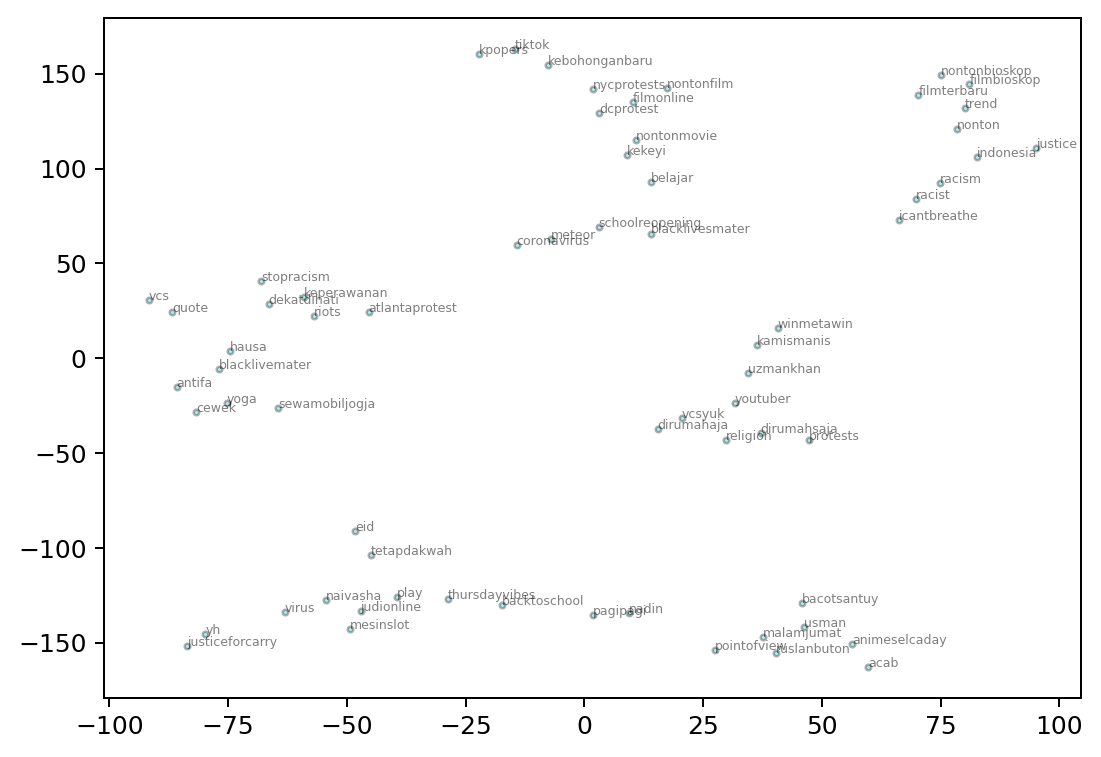

In [29]:
plot2d(model,
       words=set(hashtags),
       method = "TSNE", 
       random_state = 123, perplexity=4,
      )

In [30]:
model.wv.most_similar('black')

[('hate', 0.9825043678283691),
 ('fisik', 0.9821925759315491),
 ('your', 0.9790909886360168),
 ('skin', 0.9751538634300232),
 ('cant', 0.974022388458252),
 ('purple', 0.9728688597679138),
 ('ras', 0.9708086252212524),
 ('winmetawin', 0.9695508480072021),
 ('hype', 0.9685945510864258),
 ('rasism', 0.9671377539634705)]

In [31]:
model.wv.most_similar(positive=['amerika', 'indonesia'], negative=['racism'])

[('dunia', 0.9761533737182617),
 ('ak', 0.9685127139091492),
 ('semoga', 0.968468189239502),
 ('agama', 0.9672704339027405),
 ('kayak', 0.9646633863449097),
 ('gak', 0.9622620940208435),
 ('moots', 0.9621548652648926),
 ('karna', 0.9613953232765198),
 ('man', 0.9606394171714783),
 ('enak', 0.9580057263374329)]

## Closest Hashtag

Since we have accumulated hashtags, we can also look for similarity between tweet and hashtags's vector. First we need to get the vector of all hashtags, change the tweet into vector (using mean), then measure the cosine similarity to all the hashtag vectors. 

In [32]:
hashtag_name = [hashtag for hashtag in set(hashtags) if hashtag in model.wv.vocab]
hashtag_vector = [model.wv.get_vector(x) for x in hashtag_name]

In [33]:
def tweet2vec(words, model):
    words = np.array([model.wv.get_vector(word) for word in words if word in model.wv.vocab])
    return words.mean(axis=0)

def similar_hashtag(words, hashtag_vector, hashtag_name, model):
    result = []
    tweet_vector = tweet2vec(words, model)
    for i in range(len(hashtag_name)):
        hname = hashtag_name[i]
        hvector = hashtag_vector[i]
        distance = 1-spatial.distance.cosine(tweet_vector, hvector)
        result.append((hname, distance))
    return pd.DataFrame(result, columns=['hashtag', 'distance']).sort_values(by='distance', ascending=False).reset_index(drop=True)

here are example on how we measure list of words (preprocessed tweet) to hashtags

In [34]:
words1 = 'drama korea apa selanjutnya ya'
words2 = 'jangan rasis dong'

In [35]:
similar_hashtag(words2.split(), hashtag_vector, hashtag_name, model).head(5)

hashtag  distance
0     racism  0.974968
1  indonesia  0.968138
2     racist  0.946433
3     meteor  0.943452
4    belajar  0.940269

In [36]:
similar_hashtag(words1.split(), hashtag_vector, hashtag_name, model).head(5)

hashtag  distance
0      belajar  0.976736
1       kekeyi  0.972512
2    dcprotest  0.951983
3  filmterbaru  0.947506
4        riots  0.944672

From two example above, we can use the word2vec model to give hashtag recomendations. Also this technique is not that great compared to mor complex algorithm, but it's work.

In [38]:
# Menyimpan model word2vec
# model.save('w2v_model')

# 4. Hide tweet message using Steganography with Markov Chain Model

In credit to complete Arga's Task

## Download Ebook from gutenberg

We are using "The Adventure of Sherlock Holmes" free ebook downloaded from gutenberg.org as our corpus. You can download the ebook using both R or Python. 

using R :
```r
library(gutenbergr)
text <- gutenberg_download(1661)
```

or Python: 
```python
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
text = strip_headers(load_etext(1661)).strip()
```




Below are some preprocess to extract only the textual content of the ebook. The resulting corpus might not be 100% of the original ebook.

In [54]:
# sherlock = pd.read_csv('data/sherlock.csv')
# text = '\n'.join(sherlock['text'])
# with open('data/sherlock_text.txt', 'w') as file:
#     file.write(text)

Now we have the ebook in txt format. You can read using python using: 


In [29]:
with open('data/sherlock_text.txt', 'r') as file:
    corpus = file.read()

## Create Markov Chain

In [1]:
import markov
import utils
import variableSizeCode

import importlib

In [17]:
importlib.reload(utils)
importlib.reload(variableSizeCode)
importlib.reload(markov)

<module 'markov' from '/Users/iqbalbasyar/Documents/onego/Twitter Analysis/blacklivesmatter/markov.py'>

In [3]:
# create markov bi-gram model from sherlox txt, save it as json file
markov.createMarkovChainFromFile(inputFile='data/sherlock_text.txt', outputFile='data/markov2.json', wordsPerState=2)

In [4]:
# test markov
markov.testMarkovChain('data/markov2.json')

OK: no errors found in markov file


In [5]:
# Example generate text with markov (random 10x)
for i in range (10):
    generated_text = utils.wordListToText(markov.generateTextUsingMarkovChain('data/markov2.json', wordsPerState=2))
    print(f"Generated Text #{i}:\n{generated_text}\n")

Generated Text #0:
He was handy and would come cheap

Generated Text #1:
But on the white creases of his belief

Generated Text #2:
And i have heard of since

Generated Text #3:
For his chambers

Generated Text #4:
Was shaking his fists fiercely at the door

Generated Text #5:
Is it

Generated Text #6:
He is indeed the culprit is mister st

Generated Text #7:
Went down to catch the last item

Generated Text #8:
You see nothing in the morning light revealed it to turn to mister lestrade of scotland yard and smoked very heavily

Generated Text #9:
A lumberroom up among the crowd to protect the lady and gentleman



## Encoding
What markov model can be used for, is to generate text based on the probability given a sequence of characters we are going to encode. 
We change the plain text into its binary from each character's ordinal number, then predict what's most suitable word representing it in the corpus

In [20]:
# encode a textfile
variableSizeCode.encodeDataFromFile(
    inputFile='data/plain_tweet2.txt', 
    outputFile='data/encoded_tweet2.txt', 
    markovInputFile='data/markov2.json', 
    textFileFormat=True, 
    wordsPerState=2)

wrote 784 bits
elapsed time: 0.9256319999694824 seconds
 - encoding time: 0.2892169952392578 seconds


## Decoding

To put it simple, the process of the decoding is the reverse of encoding. We predict the word's binary form using markov chain, and return the character

In [21]:
# decode a textfile
variableSizeCode.decodeDataFromFile(
    inputFile='data/encoded_tweet2.txt',
    outputFile='data/decoded_tweet2.txt', 
    markovInputFile='data/markov2.json', 
    textFileFormat = True, 
    wordsPerState = 2)

read 784 bits
elapsed time: 0.47115397453308105 seconds
 - decoding time: 0.2531273365020752 seconds


In [28]:
with open('data/plain_tweet1.txt') as file:
    plain_tweet1 = file.read()
with open('data/encoded_tweet1.txt') as file:
    encoded_tweet1 = file.read()
with open('data/decoded_tweet1.txt') as file:
    decoded_tweet1 = file.read()

with open('data/plain_tweet2.txt') as file:
    plain_tweet2 = file.read()
with open('data/encoded_tweet2.txt') as file:
    encoded_tweet2 = file.read()
with open('data/decoded_tweet2.txt') as file:
    decoded_tweet2 = file.read()

print(f"""
Original Text : 
{plain_tweet1}

Encoded Text : 
{encoded_tweet1}

Decoded Text : 
{decoded_tweet1}
------------------------------

Original Text : 
{plain_tweet2}

Encoded Text : 
{encoded_tweet2}

Decoded Text : 
{decoded_tweet2}
""")


Original Text : 
Tau dulu kondisi nya, tau dulu asal-usul nya. Tau dulu penyebab dan tekanan nya. Hal yang bentuk stigma nya negatif itu gak bisa dibilang selalu negatif gitu aja.

Encoded Text : 
Had his ordinary clothes on but without finding anything which you may be interested in these little problems. There has been quite willing to undergo the wedding. For something more cheerful. And i wrote to father at bordeaux. Of which mister henry baker. And all its advantages and all those who ask for the presence of the room and i have a vague figure huddled up in despair but spaulding would not have thought sometimes that it was a widower. I saw how many were waiting. But it was not surprised to hear your majesty must pay. Then i made the sign of his suspicious looks at me as the weeks passed and nothing happened to live in winchester. And he misses me so good a wife as an actress myself. The lad could not imagine. A slow and heavy with snow and his tie under his cloak and laid it on ei